#### 5 year Forecasting With ResellerSales


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
import pyodbc 
import pandas as pd
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-4P75PCB;'
                      'Database=AdventureWorks2012;' 
                      'Trusted_Connection=yes;')


sql_for_df1 = """SELECT SOH.[OrderDate],CASE WHEN SOH.[OnlineOrderFlag] = 1 THEN 'Online' ELSE 'Reseller' END AS Sales_Channel,
                SO.[OrderQty]*SO.[UnitPrice] AS Total_Sales,
                ST.Name AS Region 
                FROM [Sales].[SalesOrderDetail] AS SO \
                INNER JOIN [Sales].[SalesOrderHeader] AS SOH \
                ON SO.SalesOrderID = SOH.SalesOrderID \
                INNER JOIN [Production].[Product] AS PP \
                ON SO.[ProductID] = PP.ProductID \
                INNER JOIN  [Production].[ProductSubcategory] AS PSC \
                ON PP.[ProductSubcategoryID] = PSC.[ProductSubcategoryID] \
                INNER JOIN [Production].[ProductCategory] AS PC \
                ON PSC.[ProductCategoryID] = PC.[ProductCategoryID] \
                INNER JOIN [Sales].[SalesTerritory] AS ST \
                ON ST.TerritoryID =SOH.TerritoryID \
                WHERE OnlineOrderFlag = '0' """

df = pd.read_sql(sql_for_df1 , conn)


conn.close()
df.head()

,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Reseller,2024.994,Southeast
1,2011-05-31,Reseller,6074.982,Southeast
2,2011-05-31,Reseller,2024.994,Southeast
3,2011-05-31,Reseller,2039.994,Southeast
4,2011-05-31,Reseller,2039.994,Southeast


In [3]:
df = pd.DataFrame(df)
df.reset_index(drop=True, inplace=True)
df


,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Reseller,2024.994,Southeast
1,2011-05-31,Reseller,6074.982,Southeast
2,2011-05-31,Reseller,2024.994,Southeast
3,2011-05-31,Reseller,2039.994,Southeast
4,2011-05-31,Reseller,2039.994,Southeast
...,...,...,...,...
60914,2014-05-01,Reseller,316.860,Southwest
60915,2014-05-01,Reseller,809.760,Southwest
60916,2014-05-01,Reseller,3274.800,Southwest
60917,2014-05-01,Reseller,97.182,Southwest


In [4]:
df.OrderDate.max() 

Timestamp('2014-05-01 00:00:00')

In [5]:
df.OrderDate.min()

Timestamp('2011-05-31 00:00:00')

In [82]:
#df['OrderDate']=pd.to_datetime(df['OrderDate'])

In [6]:
online_channel= df.loc[df['Region'] == 'United Kingdom',:]
online_channel

,OrderDate,Sales_Channel,Total_Sales,Region
8743,2012-05-30,Reseller,1561.6364,United Kingdom
8744,2012-05-30,Reseller,939.5880,United Kingdom
8745,2012-05-30,Reseller,939.5880,United Kingdom
8746,2012-05-30,Reseller,86.5212,United Kingdom
8747,2012-05-30,Reseller,1561.6364,United Kingdom
...,...,...,...,...
60667,2014-05-01,Reseller,89.9820,United Kingdom
60668,2014-05-01,Reseller,32.3940,United Kingdom
60669,2014-05-01,Reseller,10.7880,United Kingdom
60670,2014-05-01,Reseller,2016.8820,United Kingdom


### Data Preprocessing

In [7]:
cols = ['Sales_Channel','Region']
online_channel.drop(cols, axis=1, inplace=True)
online_channel = online_channel.sort_values('OrderDate')
online_channel.isnull().sum()


OrderDate      0
Total_Sales    0
dtype: int64

In [8]:
online_channel = online_channel.groupby('OrderDate')['Total_Sales'].sum().reset_index()
online_channel

,OrderDate,Total_Sales
0,2012-05-30,82046.9992
1,2012-06-30,183017.9479
2,2012-07-31,209046.7943
3,2012-08-30,63444.2626
4,2012-09-30,140676.8624
5,2012-10-30,166016.1545
6,2012-11-30,36790.8369
7,2012-12-31,121295.3011
8,2013-01-28,115841.3487
9,2013-02-28,48205.2292


### Indexing with Time Series Data

In [9]:
online_channel = online_channel.set_index('OrderDate')
online_channel.index

DatetimeIndex(['2012-05-30', '2012-06-30', '2012-07-31', '2012-08-30',
               '2012-09-30', '2012-10-30', '2012-11-30', '2012-12-31',
               '2013-01-28', '2013-02-28', '2013-03-30', '2013-04-30',
               '2013-05-30', '2013-06-30', '2013-07-31', '2013-08-30',
               '2013-09-30', '2013-10-30', '2013-11-30', '2013-12-31',
               '2014-01-29', '2014-03-01', '2014-03-31', '2014-05-01'],
              dtype='datetime64[ns]', name='OrderDate', freq=None)

current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [10]:
y = online_channel['Total_Sales'].resample('MS').mean()
y = y.fillna(y.bfill())

In [11]:
y['2014':]

OrderDate
2014-01-01    310933.20660
2014-02-01    154722.50125
2014-03-01    154722.50125
2014-04-01    428060.27480
2014-05-01    428060.27480
Freq: MS, Name: Total_Sales, dtype: float64

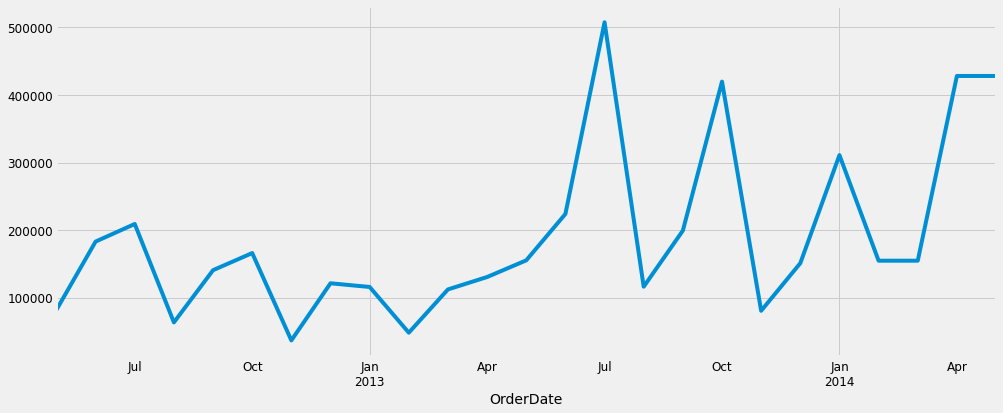

In [12]:
#Visualizing Country Sales Time Series Data
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

### Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [13]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [14]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:663.1356363364944
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:314.27145501015684
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:330.15450527486297
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:337.33134171518896
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:318.01078474119714
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:28.964963575458672
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:626.8143601416408
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:299.68230720634807
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:298.13864804565657
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:353.3479783232975
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:301.20890389622275
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:32.00128660154928
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:618.9847859208055
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:296.05418377970415
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:302.96152505076384
A

 ### Fitting an ARIMA Time Series Model

In [15]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5122         -0        inf      0.000      -0.512      -0.512
ma.L1          1.2145         -0       -inf      0.000       1.215       1.215
ar.S.L12            0         -0        nan        nan           0           0
ma.S.L12            0         -0        nan        nan           0           0
sigma2      1.738e+10         -0       -inf      0.000    1.74e+10    1.74e+10


### Validating forecasts

In [16]:
pred = results.get_prediction(start=pd.to_datetime('2013-06-01'), end=pd.to_datetime('2014-05-01 05:40:00'),dynamic=True, full_results=True)
pred_ci = pred.conf_int()



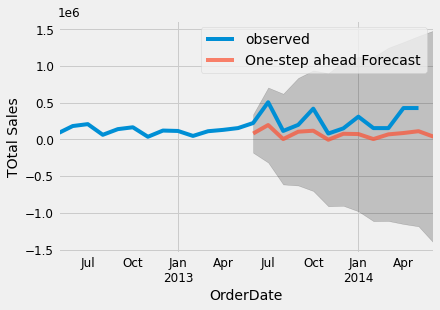

In [17]:
ax = y['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('OrderDate')
ax.set_ylabel('TOtal Sales')
plt.legend()

plt.show()

In [18]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 60240034268.48


In [19]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 245438.45


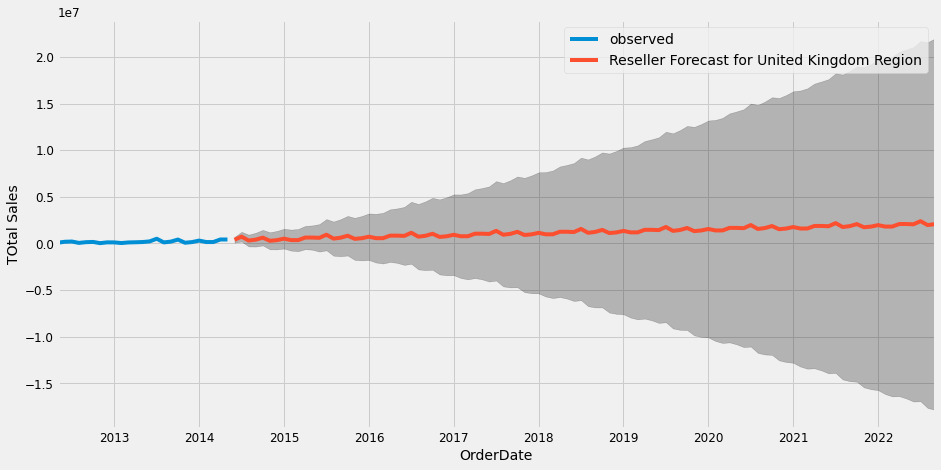

In [21]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Reseller Forecast for United Kingdom Region')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('OrderDate')
ax.set_ylabel('TOtal Sales')
plt.legend()
plt.show()